In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import os
import re
from scipy.optimize import curve_fit

from jaqalpaq.parser import parse_jaqal_string
from jaqalpaq.emulator import run_jaqal_circuit

mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'

Load the raw RAV and XEB result data from the IBM Q run.

In [2]:
[rav50, rav100, rav500, rav1000, rav5000] = np.load('data/ibmq_manila/ravcounts.npy')

def discard_odd(full):
    full = np.array(full)
    return np.hstack((full[:,0:44:2,:], full[:,44:,]))

[rav50, rav100, rav500, rav1000, rav5000] = [discard_odd(counts) for counts in [rav50, rav100, rav500, rav1000, rav5000]]
rav_results = {
    50: rav50,
    100: rav100,
    500: rav500,
    1000: rav1000,
    5000: rav5000,
}

shots_per_run = 50
run_count = rav_results[shots_per_run].shape[0]
rav_results[shots_per_run].shape

(10, 50, 4)

In [3]:
[xeb50, xeb100, xeb500, xeb1000, xeb5000] = np.load('data/ibmq_manila/xebcounts.npy')

def discard_odd(full):
    full = np.array(full)
    return np.hstack((full[:,0:44:2,:], full[:,44:,]))

[xeb50, xeb100, xeb500, xeb1000, xeb5000] = [discard_odd(counts) for counts in [xeb50, xeb100, xeb500, xeb1000, xeb5000]]
xeb_results = {
    50: xeb50,
    100: xeb100,
    500: xeb500,
    1000: xeb1000,
    5000: xeb5000,
}

shots_per_run = 50
run_count = xeb_results[shots_per_run].shape[0]
xeb_results[shots_per_run].shape

(10, 50, 4)

In [4]:
k_list = list(xeb_results.keys())
k_list

[50, 100, 500, 1000, 5000]

Load the ideal simulated results of the RAV and XEB sequences.

In [5]:
simulated_results_rav = np.loadtxt('data/simulated_results_rav.txt', dtype=int)
simulated_results_rav = np.hstack((simulated_results_rav[0:44:2], simulated_results_rav[44:]))
simulated_results_rav = simulated_results_rav / 1e6
simulated_results_rav.shape

(50,)

In [6]:
simulated_results_xeb = np.loadtxt('data/simulated_results_xeb.txt', dtype=int)
simulated_results_xeb = np.vstack((simulated_results_xeb[0:44:2,:], simulated_results_xeb[44:,:]))
simulated_results_xeb = simulated_results_xeb / 1e6
simulated_results_xeb.shape

(50, 4)

In [7]:
DIM = 4   # 2-qubit circuits

def exponential_func(x, alpha):
    return alpha**x
        
def get_2Q_gate_count(jaqal):
    code_array = jaqal.split("\n")
    code_array = code_array[5:-1]
    total_2q_gate_count = 0
    for rotation in code_array:
        rotation_array = rotation.split(" ")
        gate_type = rotation_array[0]
        if gate_type.startswith("MS"):
            total_2q_gate_count += 1
    return total_2q_gate_count

## RAV

In [8]:
rav_fidelities = {}

for k in k_list:
    shots_per_run = k

    def files_to_list(directory):
        jaqal_files = [f'{directory}/{f}' for f in os.listdir(directory)]
        jaqal_circuits = []
        for jaqal_file in jaqal_files:
            with open(jaqal_file, mode='r') as f:
                jaqal = ''.join(f.readlines())
                circuit_i = int(re.search('rav\/(.*)_1.txt', jaqal_file).group(1))
                circuit_i = (circuit_i // 2) - 1  # convert circuit_i to an index between 0 and 49
                assert 0 <= circuit_i and circuit_i <= 49
                total_2q_gate_count = get_2Q_gate_count(jaqal)
                pure_probs = [simulated_results_rav[circuit_i]]
                sampled_probs = rav_results[shots_per_run][:,circuit_i,:]/shots_per_run
                jaqal_circuits.append({
                    'circuit_i': circuit_i,
                    'jaqal': jaqal,
                    'cycle_depth': total_2q_gate_count,
                    'pure_probs': pure_probs,
                    'sampled_probs': sampled_probs,
                })
        return jaqal_circuits

    dir_name = "data/sequences/rav"
    records = files_to_list(dir_name)
    
    DIM = 4   # 2-qubit circuits
    records_by_run = [copy.deepcopy(records) for _ in range(run_count)]

    for run_idx, records in enumerate(records_by_run):
        for record in records:
            record.update(
                sampled_probs=record['sampled_probs'][run_idx],
            )
    
    rav_fidelities[k] = []

    for run_idx, records in enumerate(records_by_run):
        from scipy.optimize import curve_fit
        
        # ignore run ranges that we observe to have abnormalities
        if shots_per_run == 50 and run_idx in [0,1,2]:
            continue    
        if shots_per_run == 100 and run_idx in [7,8,9]:
            continue
        if shots_per_run == 5000 and run_idx in [7,8]:
            continue

        success_rates = [(record["sampled_probs"][0] - 1/DIM) / (record["pure_probs"][0] - 1/DIM) for record in records]
        total_layer_counts = [record["cycle_depth"] for record in records]

        x_RAV = np.linspace(min(total_layer_counts),max(total_layer_counts),100)
        popt_RAV, pcov = curve_fit(exponential_func, total_layer_counts, success_rates)
        alpha_RAV = popt_RAV[0]
        rav_fidelities[k].append(alpha_RAV)

## XEB

In [9]:
xeb_fidelities = {}

for k in k_list:
    shots_per_run = k
    
    def files_to_list(directory):
        jaqal_files = [f'{directory}/{f}' for f in os.listdir(directory)]
        jaqal_circuits = []
        for jaqal_file in jaqal_files:
            with open(jaqal_file, mode='r') as f:
                jaqal = ''.join(f.readlines())
                circuit_i = int(re.search('xeb\/(.*)_1.txt', jaqal_file).group(1))
                circuit_i = (circuit_i // 2) - 1  # convert circuit_i to an index between 0 and 49
                assert 0 <= circuit_i and circuit_i <= 49
                total_2q_gate_count = get_2Q_gate_count(jaqal)
                pure_probs = simulated_results_xeb[circuit_i]
                sampled_probs = xeb_results[shots_per_run][:,circuit_i,:]/shots_per_run
                jaqal_circuits.append({
                    'circuit_i': circuit_i,
                    'jaqal': jaqal,
                    'cycle_depth': total_2q_gate_count,
                    'pure_probs': pure_probs,
                    'sampled_probs': sampled_probs,
                })
        return jaqal_circuits

    dir_name = "data/sequences/xeb"
    records = files_to_list(dir_name)
    
    DIM = 4   # 2-qubit circuits

    records_by_run = [copy.deepcopy(records) for _ in range(run_count)]

    for run_idx, records in enumerate(records_by_run):
        for record in records:
            e_u = np.sum(record['pure_probs']**2)
            u_u = np.sum(record['pure_probs']) / DIM
            m_u = np.sum(record['pure_probs'] * record['sampled_probs'][run_idx])
            record.update(
                sampled_probs=record['sampled_probs'][run_idx],
                e_u=e_u,
                u_u=u_u,
                m_u=m_u,
            )
    
    xeb_fidelities[k] = []

    for run_idx, records in enumerate(records_by_run):
        
        # ignore run ranges that we observe to have abnormalities    
        if shots_per_run == 500 and run_idx in [5,6,7]:
            continue
        if shots_per_run == 1000 and run_idx in [8,9]:
            continue

        success_rates = []
        for record in records:
            e_u = np.sum(record["pure_probs"]**2)
            u_u = np.sum(record["pure_probs"]) / DIM
            m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
            y = record["m_u"] - record["u_u"]
            x = record["e_u"] - record["u_u"]
            xeb_fidelity = (x * y) / (x ** 2)
            success_rates.append(xeb_fidelity)
        total_layer_counts = [record["cycle_depth"] for record in records]

        x_XEB = np.linspace(min(total_layer_counts),max(total_layer_counts),100)
        popt_XEB, pcov = curve_fit(exponential_func, total_layer_counts, success_rates)
        alpha_XEB = popt_XEB[0]
        xeb_fidelities[k].append(alpha_XEB)

## Plot for Figure 9(c)

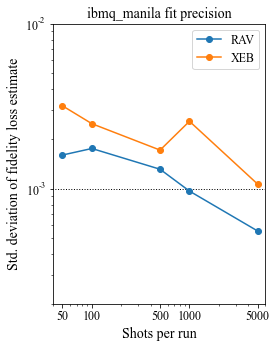

In [10]:
plt.figure(figsize=(4,5))

plt.plot(k_list, [np.std(rav_fidelities[k]) for k in k_list], 'o-', label="RAV")
plt.plot(k_list, [np.std(xeb_fidelities[k]) for k in k_list], 'o-', label="XEB")

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Shots per run', fontsize=14)
plt.ylabel(f'Std. deviation of fidelity loss estimate', fontsize=14)

plt.xticks(ticks=k_list, labels=k_list)

plt.xlim(40, 6000)
plt.ylim(2e-4, 1e-2)
plt.hlines(1e-3, xmin=0, xmax=10000, color='black', linestyle='dotted', linewidth=1)

plt.title('ibmq_manila fit precision', fontsize=14)

plt.tight_layout()
plt.legend()

plt.savefig(f'fig9c.pdf', bbox_inches='tight')
plt.show()

## Data for Figure 9(d)

In [11]:
[(k,
  1.0 - np.mean(rav_fidelities[k]),
  np.std(rav_fidelities[k]),
  np.std(rav_fidelities[k]) / (1.0 - np.mean(rav_fidelities[k]))
) for k in rav_fidelities]

[(50, 0.02100897381695599, 0.0015977001546413606, 0.07604846236477689),
 (100, 0.025142740643523398, 0.001750293182151336, 0.06961425593841139),
 (500, 0.02181685311700543, 0.0013097395354514567, 0.06003338466951327),
 (1000, 0.021939209501417145, 0.0009654945785915581, 0.044007719536530834),
 (5000, 0.020471629511935374, 0.0005528015426505958, 0.02700329948469912)]

In [12]:
[(k,
  1.0 - np.mean(xeb_fidelities[k]),
  np.std(xeb_fidelities[k]),
  np.std(xeb_fidelities[k]) / (1.0 - np.mean(xeb_fidelities[k]))
) for k in xeb_fidelities]

[(50, 0.02572201323180834, 0.003175813056621004, 0.12346673753723647),
 (100, 0.024438685206102817, 0.0024750146608023414, 0.10127446055012329),
 (500, 0.0256311302774469, 0.001711366003891373, 0.06676904160552069),
 (1000, 0.029272653779623292, 0.0025599631620558953, 0.08745237727089461),
 (5000, 0.02433807545199662, 0.0010640106092048292, 0.04371794356967288)]

In [13]:
[(k,
  ((np.std(xeb_fidelities[k])/(1.0-np.mean(xeb_fidelities[k])))
   /(np.std(rav_fidelities[k])/(1.0-np.mean(rav_fidelities[k]))))
) for k in xeb_fidelities]

[(50, 1.623527073368181),
 (100, 1.454794843167211),
 (500, 1.1121985204247193),
 (1000, 1.987205385598323),
 (5000, 1.6189852500967439)]